In [11]:
library(bnlearn)

In [12]:
### Si données locales
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA
mae.rmse <- function(m, m.hat) {
    return(list(mae=mean(abs(m - m.hat), na.rm=T), rmse=sqrt(mean((m - m.hat)^2, na.rm=T))))
}
new.m.mae.rmse <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae.rmse(m.svd2, m)
    }

In [13]:
# merge users and ratings
names(u.user)<- c('user.id','age','gender','job')
u.user <- u.user[,c(-5)]
cat.age <- function(x) floor(x/20)
u.user[, 2] <- sapply(u.user[, 2], cat.age)
for (i in 2:4){
u.user[, i] <- sapply(u.user[, i], as.factor)
}
head(u.user)
names(u.data)<- c('user.id','movie.id','rating')
u.data <- u.data[,c(-4)]
u.data[, 3] <- sapply(u.data[, 3], as.factor)
head(u.data)
u.item <- u.item[,c(-2,-3,-4,-5)]
for (i in 2:20){
u.item[, i] <- sapply(u.item[, i], as.factor)
}
head(u.item)
u.r <- merge(u.user, u.data, by = "user.id")
# merge userRating with movie to have actual movie titles instead of ids
u.r.v <- merge(u.r, u.item, by = "movie.id")
head(u.r.v)

user.id,age,gender,job
1,1,M,technician
2,2,F,other
3,1,M,writer
4,1,M,technician
5,1,F,other
6,2,M,executive


user.id,movie.id,rating
196,242,3
186,302,3
22,377,1
244,51,2
166,346,1
298,474,4


movie.id,unknown,Action,Adventure,Animation,Children.s,Comedy,Crime,Documentary,Drama,Fantasy,Film.Noir,Horror,Musical,Mystery,Romance,Sci.Fi,Thriller,War,Western
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


movie.id,user.id,age,gender,job,rating,unknown,Action,Adventure,Animation,...,Fantasy,Film.Noir,Horror,Musical,Mystery,Romance,Sci.Fi,Thriller,War,Western
1,918,2,M,scientist,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,684,1,M,student,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,660,1,M,student,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,339,1,M,lawyer,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,699,2,M,other,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,94,1,M,student,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.c], m.na[i.test.c])
    }
to.plot <- c()
cv.b <- c() 

In [23]:
set.seed(1)
i.observed <- dim(u.r.v)[1]
i.hasard <- sample(seq(1,i.observed,1), i.observed)
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, dim(u.r.v)[1])
for (i in seq_len(5)){
fold.number <- i

## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
a<-as.data.frame(u.data[1,3])
colnames(a)<-'rating'   

## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
i.test.c <- rep(FALSE,943*1682)
u.r.v.train <- u.r.v[i.train.b,]
u.r.v.test <- u.r.v[i.test.b,]
nb <- naive.bayes(u.r.v.train[,3:25],'rating')
fitted <- bn.fit(nb,u.r.v.train[,3:25] )
new.m <- m
i.test.c <- rep(FALSE,943*1682)
for (j in seq_len(fold.size)){
    new.m[u.r.v.test[j,2],u.r.v.test[j,1]]<-0
    i.test.c[943*(u.r.v.test[j,1]-1)+u.r.v.test[j,2]]<-TRUE
}
for (k in seq_len(943)){
    for (l in seq_len(1682)){
        if (new.m[k,l]==0){
            var <-data.frame(cbind(u.user[k,-1],a,u.item[l,-1]))
            new.m[k,l]<-as.numeric(predict(fitted, var))
        }
    }
}
write.table(new.m,file=paste("naiveBayes2_", toString(i), ".csv", sep = "")) # drops the rownames
write.table(i.test.c,file=paste("naiveBayesTestc2_", toString(i), ".csv", sep = "")) # drops the rownames
write.table(i.test.b,file=paste("naiveBayesTestb2_", toString(i), ".csv", sep = "")) # drops the rownames

m.train <- new.m
m.train <- m.train
m.svd <- svd(m.train)
to.plot<-rbind(to.plot,unlist(lapply(seq(30), new.m.cv)))
cv.b <- c(cv.b,mae(m.train[i.test.c], m.na[i.test.c])) 
    }


In [24]:
to.plot<-apply(to.plot,2,unlist)

In [25]:
sdev <- apply(to.plot,2,sd) 
sdev
avg <- colMeans(to.plot)
x <- 1:length(avg)
avg

[1] 0.011468822 0.009633623 0.010316054 0.009281162 0.009345715 0.011383589
 [7] 0.010038978 0.009049389 0.013076248 0.008435530 0.009025517 0.008687099
[13] 0.009161886 0.011572879 0.011192887 0.012414741 0.011666915 0.011238548
[19] 0.011019175 0.010316031 0.008917953 0.008984872 0.008730791 0.008018753
[25] 0.007874531 0.007490196 0.006812518 0.005758140 0.005426434 0.005862966

[1] 1.031561 1.079143 1.089006 1.089808 1.094136 1.092821 1.089576 1.079015
 [9] 1.072790 1.063394 1.062883 1.062437 1.061732 1.059259 1.057166 1.054063
[17] 1.050918 1.049121 1.048361 1.047356 1.046118 1.046036 1.045882 1.045786
[25] 1.045546 1.046144 1.046723 1.048177 1.049808 1.051330

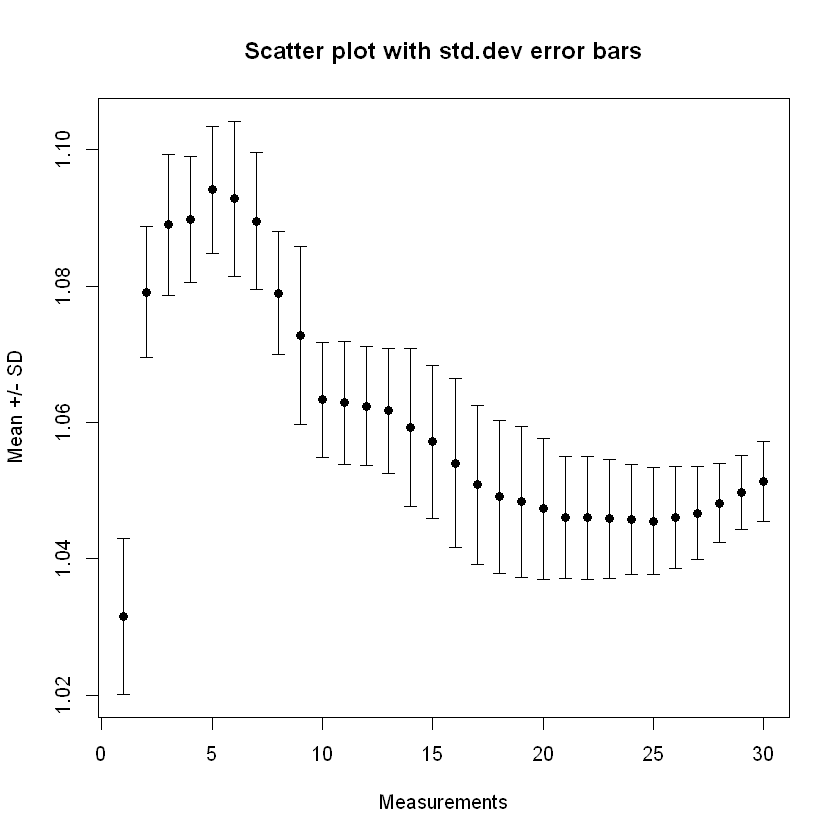

In [26]:
plot(x,colMeans(to.plot),ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Measurements", ylab="Mean +/- SD",
    main="Scatter plot with std.dev error bars"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [5]:
table = list()
test = list()

In [6]:
table[[1]] <- read.table(file=paste("naiveBayes1_1.csv", sep = "")) # drops the rownames
table[[2]] <- read.table(file=paste("naiveBayes1_2.csv", sep = "")) # drops the rownames
table[[3]] <- read.table(file=paste("naiveBayes1_3.csv", sep = "")) # drops the rownames
table[[4]] <- read.table(file=paste("naiveBayes1_4.csv", sep = "")) # drops the rownames
table[[5]] <- read.table(file=paste("naiveBayes1_5.csv", sep = "")) # drops the rownames

test[[1]] <- read.table(file=paste("naiveBayesTestc1_1.csv", sep = "")) # drops the rownames
test[[2]] <- read.table(file=paste("naiveBayesTestc1_2.csv", sep = "")) # drops the rownames
test[[3]] <- read.table(file=paste("naiveBayesTestc1_3.csv", sep = "")) # drops the rownames
test[[4]] <- read.table(file=paste("naiveBayesTestc1_4.csv", sep = "")) # drops the rownames
test[[5]] <- read.table(file=paste("naiveBayesTestc1_5.csv", sep = "")) # drops the rownames

In [9]:
to.plot <- c()
for (i in 1:5){
m.train <- data.matrix(table[[i]])
i.test.c <- unlist(test[[i]])
print(mae(m.train[i.test.c],m.na[i.test.c]))
m.svd <- svd(m.train)
to.plot<-rbind(to.plot,unlist(lapply(seq(30), new.m.cv)))
    }
to.plot<-apply(to.plot,2,unlist)

[1] 1.22005
[1] 1.22845
[1] 1.2072
[1] 1.22515
[1] 1.19855


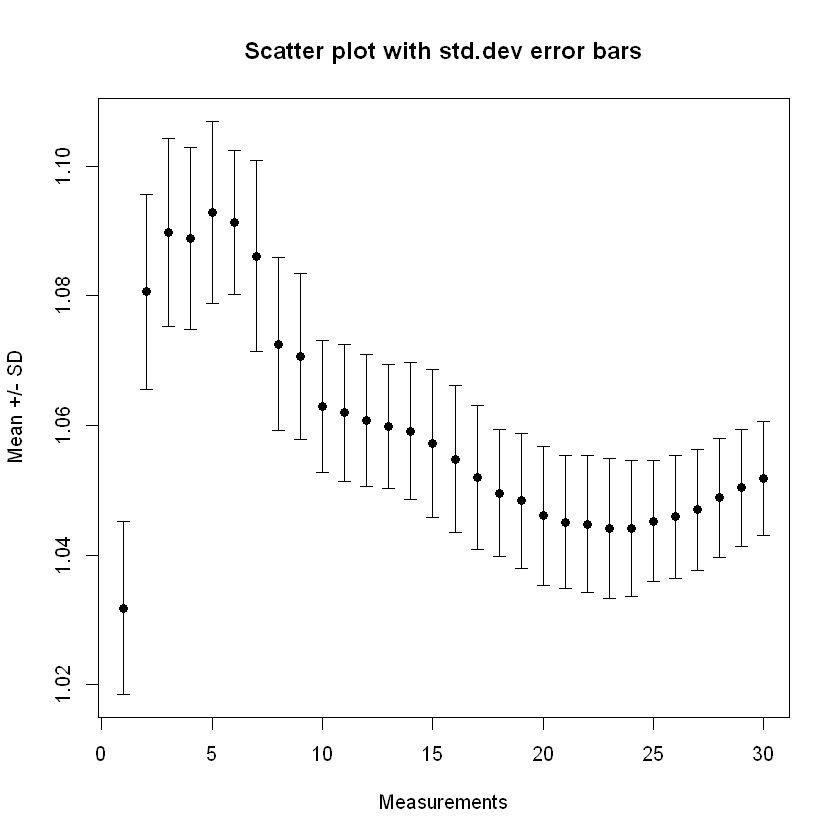

In [10]:
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
x <- 1:length(avg)
plot(x,colMeans(to.plot),ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Measurements", ylab="Mean +/- SD",
    main="Scatter plot with std.dev error bars"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)